This is how I prepare the data for the F model. I use my own dataset for this experiment
> In Our dataset, some subject has bangs covered their forehead. Becareful with this

## Import

In [1]:
import pyVHR
from pyVHR.analysis.pipeline import Pipeline

2023-03-10 11:16:08.473338: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from glob import glob
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.signal import find_peaks
import heartpy as hp
from biosppy.signals import tools, ppg
import shutil
import csv

## Prepare the video
I need to pass a video for pyVHR. My dataset is in a form of a folder with images. I need to convert it to a video. I use opencv for this purpose.

In [3]:
DATASET_ROOT = '/mnt/sdb1/Developers-EXT/physio_capture/dataset'

In [ ]:
subject_name = 'adin6'
# the img_dir_path is 'dataset/(subect_name)/rgb'
img_dir_path = os.path.join(DATASET_ROOT, subject_name, 'rgb')
img_frame_individual_path = glob(os.path.join(img_dir_path, "*.jpg"))
img_frame_individual_path.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
print(f"Total number of frames: {len(img_frame_individual_path)}")

In [ ]:
# convert all image in the img_Frame_individual_path from 1080 to 720
for image in img_frame_individual_path:
    img = cv2.imread(image)
    img = cv2.resize(img, (1280, 720))
    cv2.imwrite(image, img)

In [8]:
FPS = 30
size = (1280, 720)
save_path = 'temp_video.avi'

In [ ]:
out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'MJPG'), FPS, size)

# read every image and write to video
for img in img_frame_individual_path:
    frame = cv2.imread(img)
    out.write(frame)

# release the video
out.release()

## Get the rPPG signal

In this case, I use the POS method

In [ ]:
from inspect import getmembers, isfunction
av_meths = getmembers(pyVHR.BVP.methods, isfunction)
available_methods = [am[0] for am in av_meths]
print(f"Available methods: {available_methods}")

Up until now, I dont have any proper method to select the landmark. I referencing this [image](canonical_face_model_uv_visualization.png) You can zoom it and find landmark numbers.

In [6]:
w_size = 60
method = 'cpu_POS'
pipe = Pipeline()
# forehead_mediapipe_landmark = [69, 108, 151, 337, 299, 333, 334, 296, 136, 9, 107, 66, 8, 285, 295, 282, 55, 65, 52]
# cheek_mediapipe_landmark = [277, 349, 450, 449, 448, 261, 265, 372, 264, 447, 345, 229, 348, 347, 346, 345, 447, 264, 386, 352, 280, 425, 266, 423, 426, 427, 416, 433]
forehead_mediapipe_landmark = [8, 9]
cheek_mediapipe_landmark = [352, 280]

In [9]:
bvps_win_fh, timesES_fh, bpmES_fh = pipe.run_on_video(
    videoFileName=save_path,
    method=method,
    winsize=w_size,
    cuda=True,
    verb=False,
    ldmks_list=forehead_mediapipe_landmark,
    roi_approach='patches',
    estimate='median',
)

bvps_win_ch, timesES_ch, bpmES_ch = pipe.run_on_video(
    videoFileName=save_path,
    method=method,
    winsize=w_size,
    cuda=True,
    verb=False,
    ldmks_list=cheek_mediapipe_landmark,
    roi_approach='patches',
    estimate='median',
)

# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# convert list into numpy
signal_array = np.array(bvps_win_fh)
print(f"shape before reshape: {signal_array.shape}")
# current dim (1,19,1800) reshape into (19,1800)
signal_array = signal_array.reshape(19, 1800)
print(f"signal_array shape: {signal_array.shape}")
signal_array = signal_array.T
print(f"signal_array shape: {signal_array.shape}")

In [ ]:
# transform from 19 channels to 1 channels using pca
pca = PCA(n_components=1)
pca.fit(signal_array)
signal_transformed = pca.transform(signal_array)
signal_transformed = signal_transformed.T
print(f"signal_array_transformed shape: {signal_transformed.shape}")

In [ ]:
# compare between signal_array[0][5] and signal_transformed using subplot top and bottom
plt.figure(figsize=(20, 7))
plt.subplot(2, 1, 1)
plt.plot(bvps_win_fh[0][5])
plt.subplot(2, 1, 2)
plt.plot(signal_transformed[0])
plt.show()

In [ ]:
rPPG_signal_main_filtered = hp.filter_signal(
    signal_transformed[0],
    cutoff = [1, 1.8],
    sample_rate = FS,
    filtertype = 'bandpass',
)

rPPG_signal_main_peak, _ = find_peaks(rPPG_signal_main_filtered)
print(f"Len of peak: {len(rPPG_signal_main_peak)}")

plt.figure(figsize=(20, 7))
plt.plot(rPPG_signal_main_filtered)
plt.show()

In [ ]:
bvps_forehead = bvps_win_fh[0][4]
bvps_cheek = bvps_win_ch[0][0]

# compare between forehead and cheek in subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
ax1.plot(bvps_forehead)
ax1.set_title(f"Forehead | BPM: {bpmES_fh[0]:.2f}")
ax2.plot(bvps_cheek)
ax2.set_title(f"Cheek | BPM: {bpmES_ch[0]:.2f}")
plt.show()


## Obtain the Spectrum using FFT

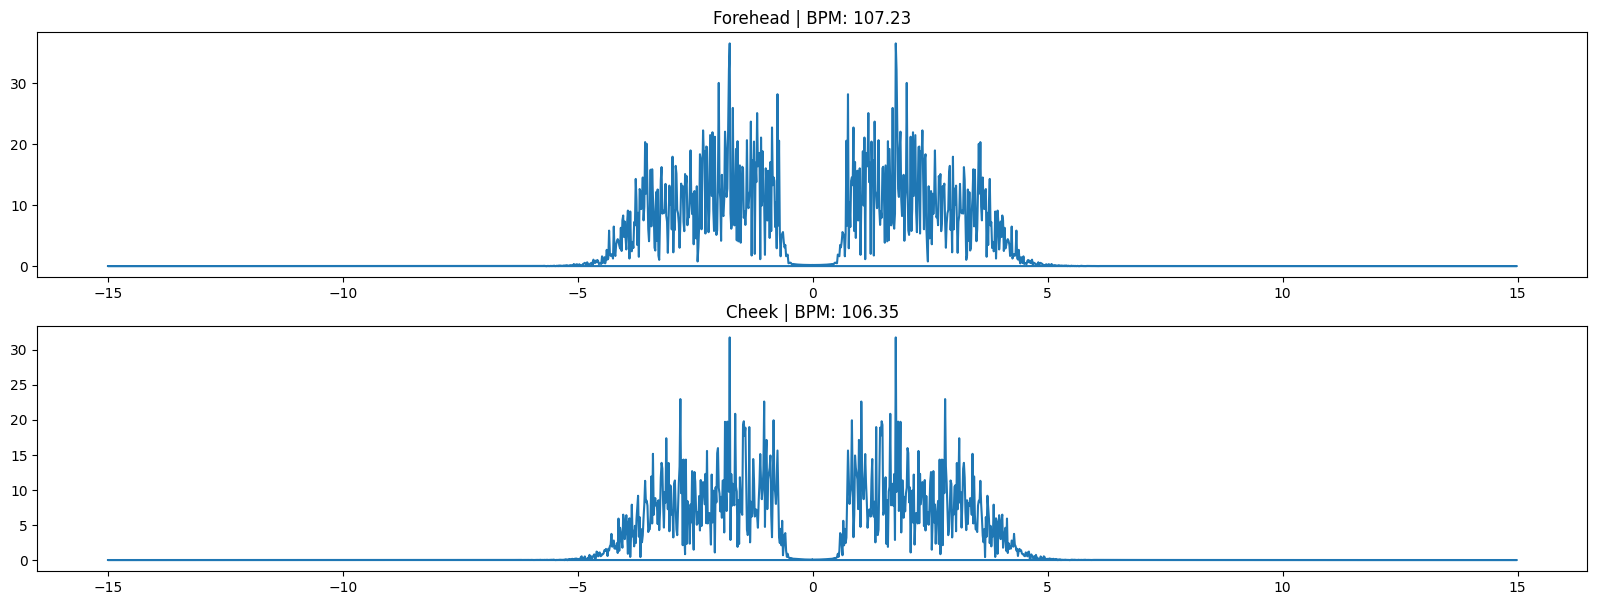

In [11]:
bvps_forehead = bvps_win_fh[0][0]
bvps_cheek = bvps_win_ch[0][0]
FS = 30
fft_bvps_forehead = np.fft.fft(bvps_forehead)
fft_bvps_cheek = np.fft.fft(bvps_cheek)
freqs_fh = np.fft.fftfreq(len(fft_bvps_forehead), 1/FS)
freqs_ch = np.fft.fftfreq(len(fft_bvps_cheek), 1/FS)

# plot the magnitude of fft using subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
ax1.plot(freqs_fh, np.abs(fft_bvps_forehead))
ax1.set_title(f"Forehead | BPM: {bpmES_fh[0]:.2f}")
ax2.plot(freqs_ch, np.abs(fft_bvps_cheek))
ax2.set_title(f"Cheek | BPM: {bpmES_ch[0]:.2f}")
plt.show()


In [18]:
# get the highest energy
max_energy_fh = np.argmax(np.abs(fft_bvps_forehead))
max_energy_ch = np.argmax(np.abs(fft_bvps_cheek))
print(f"Forehead: {abs(freqs_fh[max_energy_fh]):.2f} Hz")
print(f"Cheek: {abs(freqs_ch[max_energy_ch]):.2f} Hz")

Forehead: 1.77 Hz
Cheek: 1.77 Hz


In [20]:
phase_forehead = np.angle(fft_bvps_forehead[max_energy_fh])
phase_cheek = np.abs(np.angle(fft_bvps_cheek[max_energy_ch]))
# phase difference is the difference between the phase of the forehead and the phase of the cheek
phase_difference = np.abs(phase_forehead - phase_cheek)
print(f"Forehead phase: {phase_forehead:.2f} rad")
print(f"Cheek phase: {phase_cheek:.2f} rad")
print(f"Phase difference: {phase_difference:.2f} rad")

Forehead phase: 0.14 rad
Cheek phase: 0.62 rad
Phase difference: 0.48 rad


Referencing back to the paper to obtained the PTT

$ PTT = TimeDelay = \frac{PhaseDiff}{2 \pi \times f} $

In [24]:
if phase_forehead > phase_cheek:
    max_freqs = freqs_fh[max_energy_fh]
else:
    max_freqs = freqs_ch[max_energy_ch]

print(f"Max freqs: {max_freqs:.2f} Hz")

PTT = phase_difference / (2 * np.pi * abs(max_freqs))*1000
print(f"PTT: {PTT:.2f}")
# in ms

Max freqs: -1.77 Hz
PTT: 43.07


## Re-run the rPPG to get the signal for HR and HRV

This time we use the default landmark defined by pyVHR

In [25]:
bvps_win_main, timesES_main, bpmES_main = pipe.run_on_video(
    videoFileName=save_path,
    method=method,
    winsize=w_size,
    cuda=True,
    verb=False,
)

# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti


Len of peak: 106


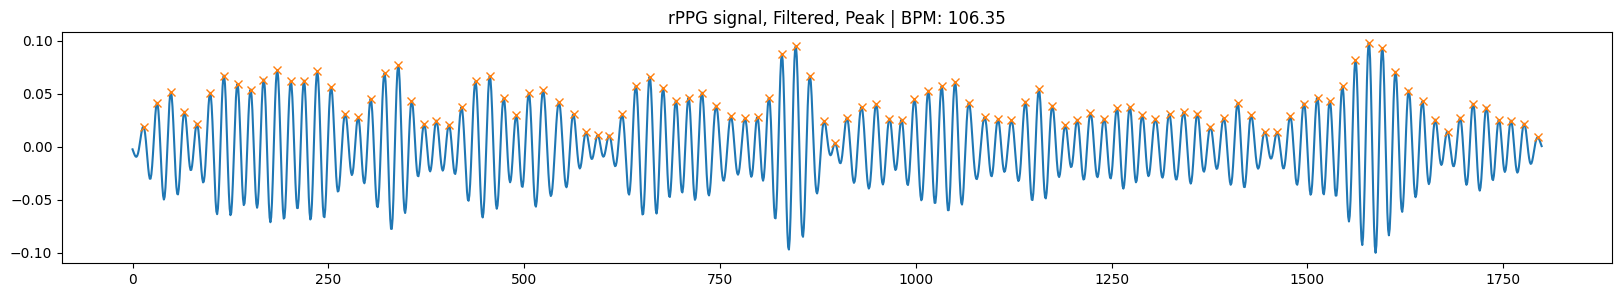

In [39]:
rPPG_signal_main = bvps_win_main[0][0]
# filter the signal using bandpass
rPPG_signal_main_filtered = hp.filter_signal(
    rPPG_signal_main,
    cutoff = [1.3, 2],
    sample_rate = FS,
    filtertype = 'bandpass',
)
rPPG_signal_main_peak, _ = find_peaks(rPPG_signal_main_filtered)
print(f"Len of peak: {len(rPPG_signal_main_peak)}")

plt.figure(figsize=(20, 3))
plt.title("rPPG signal, Filtered, Peak | BPM: {:.2f}".format(bpmES_main[0]))
plt.plot(rPPG_signal_main_filtered)
plt.plot(rPPG_signal_main_peak, rPPG_signal_main_filtered[rPPG_signal_main_peak], "x")

## Count SDNN, LF, HF, and LF/HF

In [46]:
# count the interbeats interval
ibis = np.diff(rPPG_signal_main_peak) / FS
print(f"Length of IBI: {len(ibis)}")
# calculate mean Interval
mean_interval = np.mean(ibis)
# calculate SDNN
sdnn = np.std(ibis) * 1000
print(f"Mean Interval: {mean_interval:.2f} s")
print(f"SDNN: {sdnn:.2f} ms")

Length of IBI: 105
Mean Interval: 0.57 s
SDNN: 35.45 ms


In [54]:
# resample IBIs to a uniform scale
t = np.arange(0, ibis.sum(), 1/FS)
ibi_interp = np.interp(t, np.cumsum(ibis), ibis)
print(f"IBI interpolation length: {len(ibi_interp)}")
# compute the power spectrum of the IBI using Lomb-Scargle Periodogram
freqs, power = sig.welch(ibi_interp, fs=FS, nperseg=1024)
# Define frequency bands for LF and HF
lf_band = (0.04, 0.15)  # in Hz
hf_band = (0.15, 0.4)  # in Hz
lf_power = np.trapz(power[(freqs >= lf_band[0]) & (freqs <= lf_band[1])])
hf_power = np.trapz(power[(freqs >= hf_band[0]) & (freqs <= hf_band[1])])
print(f"LF power: {lf_power:.2f}")
print(f"HF power: {hf_power:.2f}")

# compute the LF/HF ratio
lf_hf_ratio = lf_power / hf_power
print(f"LF/HF ratio: {lf_hf_ratio:.2f}")


IBI interpolation length: 1780
LF power: 0.01
HF power: 0.03
LF/HF ratio: 0.26


## List all 7 features for f-Net

In [ ]:
print(f"1. Heart Rate: {bpmES_main[0]:.2f} bpm")
print(f"2. SDNN: {sdnn:.2f} s")
print(f"3. LF power: {lf_power:.2f}")
print(f"4. HF power: {hf_power:.2f}")
print(f"5. LF/HF ratio: {lf_hf_ratio:.2f}")
print(f"6. PTT: {PTT_inms:.2f} ms")
print(f"7. Body Mass Index: FROM THE CSV DATASET OR YOU CAN REMOVE THIS")

## Let's obtained the data for the whole dataset

In [57]:
class rPPGtoBPDataset():
    def __init__(self, root_dir, excluded_scenario: list = [1,2,3,4,5]):
        self.root_dir = root_dir
        self.subjects = self.populate_subject(root_dir, excluded_scenario)
        self.subjects = self.check_integrity_rgb(root_dir, self.subjects)
        self.FS = 30
        print(f"Total subjects: {len(self.subjects)}")
        self.subjects = self.subjects[10:]
        self.run_pipeline(self.subjects)

    def run_pipeline(self, subjects):
        for name in subjects:
            print(f"Processing subject {name} | {subjects.index(name)+1}/{len(subjects)}")
            self.convert_img_to_vid(name)
            dict_features, bvps_main, bvps_cheek, bvps_forehead = self.get_rppg()

            # save the data. The exported data path is './dataset/(name)'
            export_data_path = os.path.join('./dataset', name)
            if not os.path.exists(export_data_path):
                os.makedirs(export_data_path)

            # save dict_features (as dict) to csv
            csv_full_path = os.path.join(export_data_path, "data.csv")
            with open(os.path.join(csv_full_path), "w") as f:
                w = csv.DictWriter(f, dict_features.keys())
                w.writeheader()
                w.writerow(dict_features)

            # save the bvps to csv using numpy
            np.savetxt(os.path.join(export_data_path, "bvps_main.csv"), bvps_main, delimiter=",")
            np.savetxt(os.path.join(export_data_path, "bvps_cheek.csv"), bvps_cheek, delimiter=",")
            np.savetxt(os.path.join(export_data_path, "bvps_forehead.csv"), bvps_forehead, delimiter=",")



    def populate_subject(self, root_dir, excluded_scenario):
        # get every folder in the root directory
        subjects = sorted(os.listdir(root_dir))
        
        excluded_subjects = []
        for subject in subjects:
            if int(subject[-1]) in excluded_scenario:
                excluded_subjects.append(subject)
        subjects = [subject for subject in subjects if subject not in excluded_subjects]
        return subjects
    
    def check_integrity_rgb(self, root_dir, subjects):
        excluded_subjects = []
        for subject in subjects:
            if len(glob(os.path.join(root_dir, subject, "rgb") + "/*.jpg")) != 1800:
                excluded_subjects.append(subject)
        subjects = [subject for subject in subjects if subject not in excluded_subjects]
        print(f"Excluded subjects: {excluded_subjects}")
        return subjects
    
    def populate_rgb_list(self, subject_name):
        rgb_list = sorted(os.listdir(os.path.join(self.root_dir, subject_name, "rgb")))
        rgb_list.sort(key=lambda f: int("".join(filter(str.isdigit, f))))
        return rgb_list
    
    def convert_img_to_vid(self, subject_name):
        rgb_list = self.populate_rgb_list(subject_name)

        # if folder exists, delete it
        if os.path.exists("temp_working_folder"):
            shutil.rmtree("temp_working_folder")

        # if there's a file named "temp_video.avi", delete it
        if os.path.exists("temp_video.avi"):
            os.remove("temp_video.avi")

        if not os.path.exists("temp_working_folder"):
            os.mkdir("temp_working_folder")

        for image in rgb_list:
            full_path = os.path.join(self.root_dir, subject_name, "rgb", image)
            save_path = os.path.join("temp_working_folder", image)
            img = cv2.imread(full_path)
            img = cv2.resize(img, (1280, 720))
            cv2.imwrite(save_path, img)

        # convert the images to video
        FPS = 30
        size = (1280, 720)
        save_path = 'temp_video.avi'
        out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'MJPG'), FPS, size)

        # get every jpg in temp_working_folder
        img_frame_individual_path = glob("temp_working_folder/*.jpg")
        img_frame_individual_path.sort(key=lambda f: int("".join(filter(str.isdigit, f))))

        # read every image and write to video
        for img in img_frame_individual_path:
            frame = cv2.imread(img)
            out.write(frame)

        # release the video
        out.release()


    def get_rppg(self):
        w_size = 60
        method = 'cpu_POS'
        pipe = Pipeline()
        forehead_mediapipe_landmark = [8, 9]
        cheek_mediapipe_landmark = [352, 280]

        bvps_win_fh, _ , _ = pipe.run_on_video(
            videoFileName="temp_video.avi",
            method=method,
            winsize=w_size,
            cuda=True,
            verb=False,
            ldmks_list=forehead_mediapipe_landmark,
            roi_approach='patches',
            estimate='median',
        )

        if np.array_equal(bvps_win_fh[0][0], np.zeros(5)):
            print(f"bvps_win_fh[0][0] is containing 0,0,0")
            bvps_forehead = bvps_win_fh[0][1]
        else:
            bvps_forehead = bvps_win_fh[0][0]

        bvps_win_ch, _ , _ = pipe.run_on_video(
            videoFileName="temp_video.avi",
            method=method,
            winsize=w_size,
            cuda=True,
            verb=False,
            ldmks_list=cheek_mediapipe_landmark,
            roi_approach='patches',
            estimate='median',
        )

        if np.array_equal(bvps_win_ch[0][0], np.zeros(5)):
            print(f"bvps_win_ch[0][0] is containing 0,0,0")
            bvps_cheek = bvps_win_ch[0][1]
        else:
            bvps_cheek = bvps_win_ch[0][0]

        bvps_win_main, _ , bpmES_main = pipe.run_on_video(
            videoFileName="temp_video.avi",
            method=method,
            winsize=w_size,
            cuda=True,
            verb=False,
        )

        bvps_main = bvps_win_main[0][0]
        main_bpm = bpmES_main[0]

        fft_bvps_forehead = np.fft.fft(bvps_forehead)
        fft_bvps_cheek = np.fft.fft(bvps_cheek)
        freqs_fh = np.fft.fftfreq(len(fft_bvps_forehead), 1/self.FS)
        freqs_ch = np.fft.fftfreq(len(fft_bvps_cheek), 1/self.FS)
        max_energy_fh = np.argmax(np.abs(fft_bvps_forehead))
        max_energy_ch = np.argmax(np.abs(fft_bvps_cheek))
        phase_forehead = np.angle(fft_bvps_forehead[max_energy_fh])
        phase_cheek = np.angle(fft_bvps_cheek[max_energy_ch])
        
        if max_energy_fh > max_energy_ch:
            freq_max = freqs_fh[max_energy_fh]
        else:
            freq_max = freqs_ch[max_energy_ch]

        phase_difference = np.abs(phase_forehead - phase_cheek)
        PTT = abs(phase_difference) / (2 * np.pi * abs(freq_max)) * 1000

        rPPG_signal_main_filtered = hp.filter_signal(
            bvps_main,
            cutoff = [1.3, 2],
            sample_rate = self.FS,
            filtertype = 'bandpass',
        )
        rPPG_signal_main_peak, _ = find_peaks(rPPG_signal_main_filtered)
        ibis = np.diff(rPPG_signal_main_peak) / self.FS
        mean_interval = np.mean(ibis)
        sdnn = np.std(ibis) * 1000
        t = np.arange(0, ibis.sum(), 1/self.FS)
        ibi_interp = np.interp(t, np.cumsum(ibis), ibis)
        freqs, power = sig.welch(ibi_interp, fs=self.FS, nperseg=1024)
        lf_band = (0.04, 0.15)  # in Hz
        hf_band = (0.15, 0.4)  # in Hz
        lf_power = np.trapz(power[(freqs >= lf_band[0]) & (freqs <= lf_band[1])])
        hf_power = np.trapz(power[(freqs >= hf_band[0]) & (freqs <= hf_band[1])])
        lf_hf_ratio = lf_power / hf_power

        # return as dictionary
        dict_features =  {
                "main_bpm": main_bpm,
                "ptt": PTT,
                "sdnn": sdnn,
                "lf_hf_ratio": lf_hf_ratio,
                "lf_power": lf_power,
                "hf_power": hf_power,
            }
        
        return dict_features, bvps_main, bvps_cheek, bvps_forehead
        

        

In [58]:
DATASET_ROOT = '/mnt/sdb1/Developers-EXT/physio_capture/dataset'
process_data = rPPGtoBPDataset(root_dir=DATASET_ROOT)

Excluded subjects: ['afa6', 'pulpen6']
Total subjects: 68
Processing subject aqua6 | 1/58
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
Processing subject ara6 | 2/58
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
Processing subject arnold6 | 3/58
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
Processing subject bunny6 | 4/58
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080